# Введение в анализ данных (первый семестр)
# Задание №3

*** Конопаткин Олег, BD11 ***

Данные: **"NYS Income Tax Components"** (компоненты доходов и налогов в Нью-Йорке) <br>
https://www.kaggle.com/new-york-state/nys-income-tax-components

In [1]:
import pandas as pd 
import datetime
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from pylab import rcParams
import seaborn as sns
import itertools
from scipy import stats

%matplotlib inline

C:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


***Первичный анализ данных***
Данные собраны Нью-Йоркским Государственным Департаментом Налогов и Финансов (New York State Department of Taxation and Finance). Одна запись о человеке соответствует суммарным данным по нему за один год.

In [2]:
raw_data = pd.read_csv("data/income-tax-components-by-size-of-income-by-place-of-residence-beginning-tax-year-1999.csv")
raw_data.head()

,Tax Year,Resident Type,Place of Residence,Country,State,County,Income Class,Disclosure,Number of All Returns,NY AGI of All Returns (in thousands) *,Deductions of All Returns (in thousands),Dependent Exemptions of All Returns (in thousands),Taxable Income of All Returns (in thousands),Tax Before Credits of All Returns (in thousands),Tax Liability of All Returns (in thousands) **,Place of Residence Sort Order,Income Class Sort Order
0,2012,Full-Year Resident,New York City - Bronx,United States,New York,New York City - Bronx,"Under 5,000",NaN,104069.0,1055.643,117345.426,1.000,3393.890,135.826,-6391.876,1,1
1,2012,Full-Year Resident,New York City - Bronx,United States,New York,New York City - Bronx,"5,000 - 9,999",NaN,64307.0,496242.266,450681.702,4432.182,41128.382,1645.872,-24615.196,1,2
2,2012,Full-Year Resident,New York City - Bronx,United States,New York,New York City - Bronx,"10,000 - 19,999",NaN,119772.0,1758698.784,1137785.843,91782.455,529130.486,21418.746,-76091.505,1,3
3,2012,Full-Year Resident,New York City - Bronx,United States,New York,New York City - Bronx,"20,000 - 29,999",NaN,77700.0,1917120.326,800228.058,75099.135,1041793.133,45337.183,-10043.720,1,4
4,2012,Full-Year Resident,New York City - Bronx,United States,New York,New York City - Bronx,"30,000 - 39,999",NaN,63069.0,2194122.414,680323.666,60550.951,1453247.797,69495.051,38767.032,1,5


***Tax Year*** - годовой налоговый период

***Resident Type*** - тип резидента: 
   * Full-Year Resident - человек весь год проживает и получает доход в Нью-Йорке
   * Full-Year Nonresident - весь год не в Нью-Йорке (но получает доход из налогооблагаемых источников в Нью-Йорке)
   * Part-Year Resident - только часть года проживает и получает доход в Нью-Йорке
  
***Place of Residence*** - основной адрес (место проживания) человека
   
***Country, State, County*** - уточнение Place of Residence, State и County применимы только для США, для других стран значение "Not Applicable" или "All", также страна и округ могут иметь значение "Residence Unknown". Может быть полезно для иерархии.

***Income Class*** - категория валового заработка (за год)

***Disclosure*** - NAN если информация далее раскрыта и "d/" если нет (очевидно, нужно выкинуть записи второго вида, а затем оставшийся столбец)

<br>

Далее идут собственно численные данные по доходам и налогам:

***Number of All Returns*** - число поданных налоговых отчётов(?)

***NY AGI of All Returns*** - New York Adjusted Gross Income, доходы по отчётам

***Deductions of All Returns*** - вычеты по доходам

***Dependent Exemptions of All Returns*** - вычеты по иждивенцам

***Taxable Income of All Returns*** - налогооблагаемые доходы

***Tax Before Credits of All Returns*** - налог без учёта налоговых кредитов(?)

***Tax Liability of All Returns*** - налоговые обязательства (задолженности?)

<br>

***Place of Residence Sort Order, Income Class Sort Order*** - фактически айдишники классов места жительства и группы доходов, можно оставить их, выкинув соответствующие

***Высшая цель:*** <br>
<s> таки сдать задание </s>

In [80]:
# выкидываем скрытных товарищей
data = raw_data[raw_data.Disclosure != "d/"]

# выкидываем избыточные колонки
data = data.drop(['Income Class', 'Disclosure', 'Income Class'], axis='columns')
data = data.drop(['Place of Residence Sort Order'], axis='columns')

# привести все строки к адекватному виду, чтобы не размножать классы при группировке
data['Place of Residence'] = data['Place of Residence'].map(lambda s: s.strip())

data = data.drop(['Country', 'State', 'County'], axis='columns')

# переименуем длинные названия для удобства
new_columns = ['Tax Year', 'Resident Type', 'Place of Residence Name',
               'Number of All Returns', 'Adjusted Gross Income', 'Deductions',
               'Dependent Exemptions', 'Taxable Income', 'Tax Before Credits',
               'Tax Liability', 'Income Class']
new_columns = {data.columns[i] : new_columns[i] for i in range(len(data.columns))}
data = data.rename(columns=new_columns)

num_features = ['Number of All Returns', 'Adjusted Gross Income', 'Deductions',
               'Dependent Exemptions', 'Taxable Income', 'Tax Before Credits',
               'Tax Liability']

data.head()

,Tax Year,Resident Type,Place of Residence Name,Number of All Returns,Adjusted Gross Income,Deductions,Dependent Exemptions,Taxable Income,Tax Before Credits,Tax Liability,Income Class
0,2012,Full-Year Resident,New York City - Bronx,104069.0,1055.643,117345.426,1.000,3393.890,135.826,-6391.876,1
1,2012,Full-Year Resident,New York City - Bronx,64307.0,496242.266,450681.702,4432.182,41128.382,1645.872,-24615.196,2
2,2012,Full-Year Resident,New York City - Bronx,119772.0,1758698.784,1137785.843,91782.455,529130.486,21418.746,-76091.505,3
3,2012,Full-Year Resident,New York City - Bronx,77700.0,1917120.326,800228.058,75099.135,1041793.133,45337.183,-10043.720,4
4,2012,Full-Year Resident,New York City - Bronx,63069.0,2194122.414,680323.666,60550.951,1453247.797,69495.051,38767.032,5


***Давайте рисовать графики:***

23439
23084
21516
16938
9578


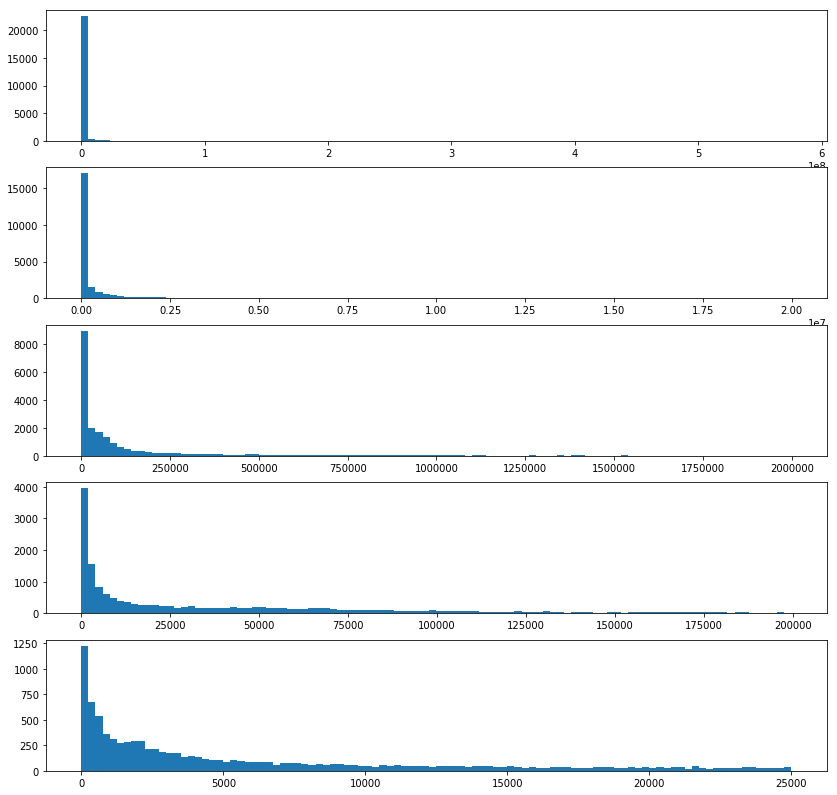

In [4]:
cur_data = data['Taxable Income'].sort_values()

fig = plt.figure(figsize=(14, 14))
ax1 = plt.subplot(511)
ax1.hist(cur_data, 100, alpha=1.0)
print(cur_data.shape[0])
ax2 = plt.subplot(512)
ax2.hist(cur_data[(-2e7 < cur_data) & (cur_data < 2e7)], 100, alpha=1.0)
print(cur_data[(-2e7 < cur_data) & (cur_data < 2e7)].shape[0])
ax3 = plt.subplot(513)
ax3.hist(cur_data[(-2e6 < cur_data) & (cur_data < 2e6)], 100, alpha=1.0)
print(cur_data[(-2e6 < cur_data) & (cur_data < 2e6)].shape[0])
ax4 = plt.subplot(514)
ax4.hist(cur_data[(-2e5 < cur_data) & (cur_data < 2e5)], 100, alpha=1.0)
print(cur_data[(-2e5 < cur_data) & (cur_data < 2e5)].shape[0])
ax5 = plt.subplot(515)
ax5.hist(cur_data[(-25000 < cur_data) & (cur_data < 25000)], 100, alpha=1.0)
print(cur_data[(-25000 < cur_data) & (cur_data < 25000)].shape[0])
plt.show()

Видно, что примерно 40% записей имеют доход до 25000, ещё примерно 30% - до 200000, 20% - до 2М, остальные 10% - больше 2М. <br> Похожая история с остальными величинами, что также видно из Boxplot-графиков:

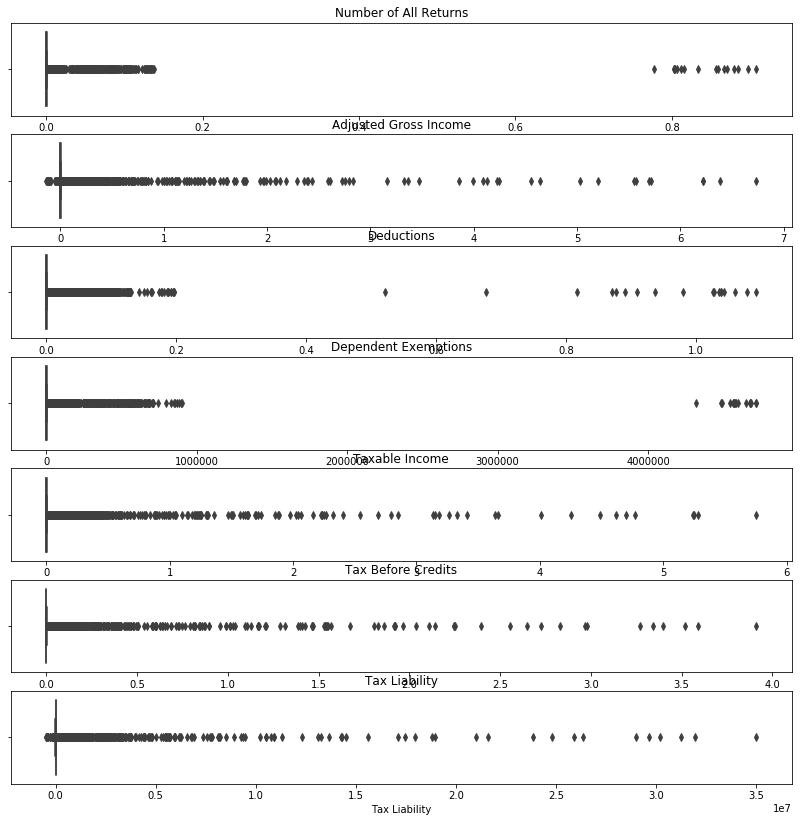

In [5]:
fig = plt.figure(figsize=(14, 14))
for i in range(len(num_features)):
    name = num_features[i]
    ax = plt.subplot(100 * (len(num_features)) + 10 + (i + 1))
    ax.set_title(name)
    sns.boxplot(data[name], ax=ax)
    

Как видно из графиков, все параметры имеют распределения, похожие на $e^{-x}$, только доход и задолженность могут быть отрицательными. Жизненное распределение с единичными миллионерами/миллиардерами, 

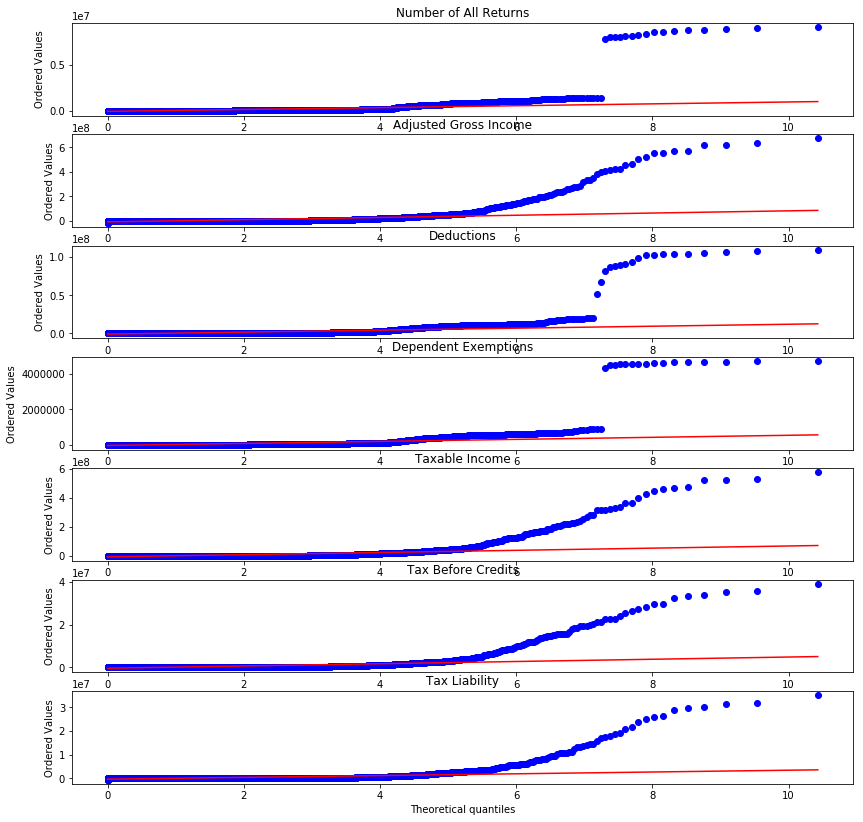

In [8]:
fig = plt.figure(figsize=(14, 14))
dist = stats.distributions.expon()
for i in range(len(num_features)):
    name = num_features[i]
    ax = plt.subplot(100 * (len(num_features)) + 10 + (i + 1))
    stats.probplot(data[name], dist = dist, plot = ax)
    ax.set_title(name)
    

ну почти, в наших распределениях хвосты явно более тяжёлые, особенно резкие выбросы с большими значениями почему-то наблюдаются для вычетов, возможно это какие-то организации, освобождённые от налогов

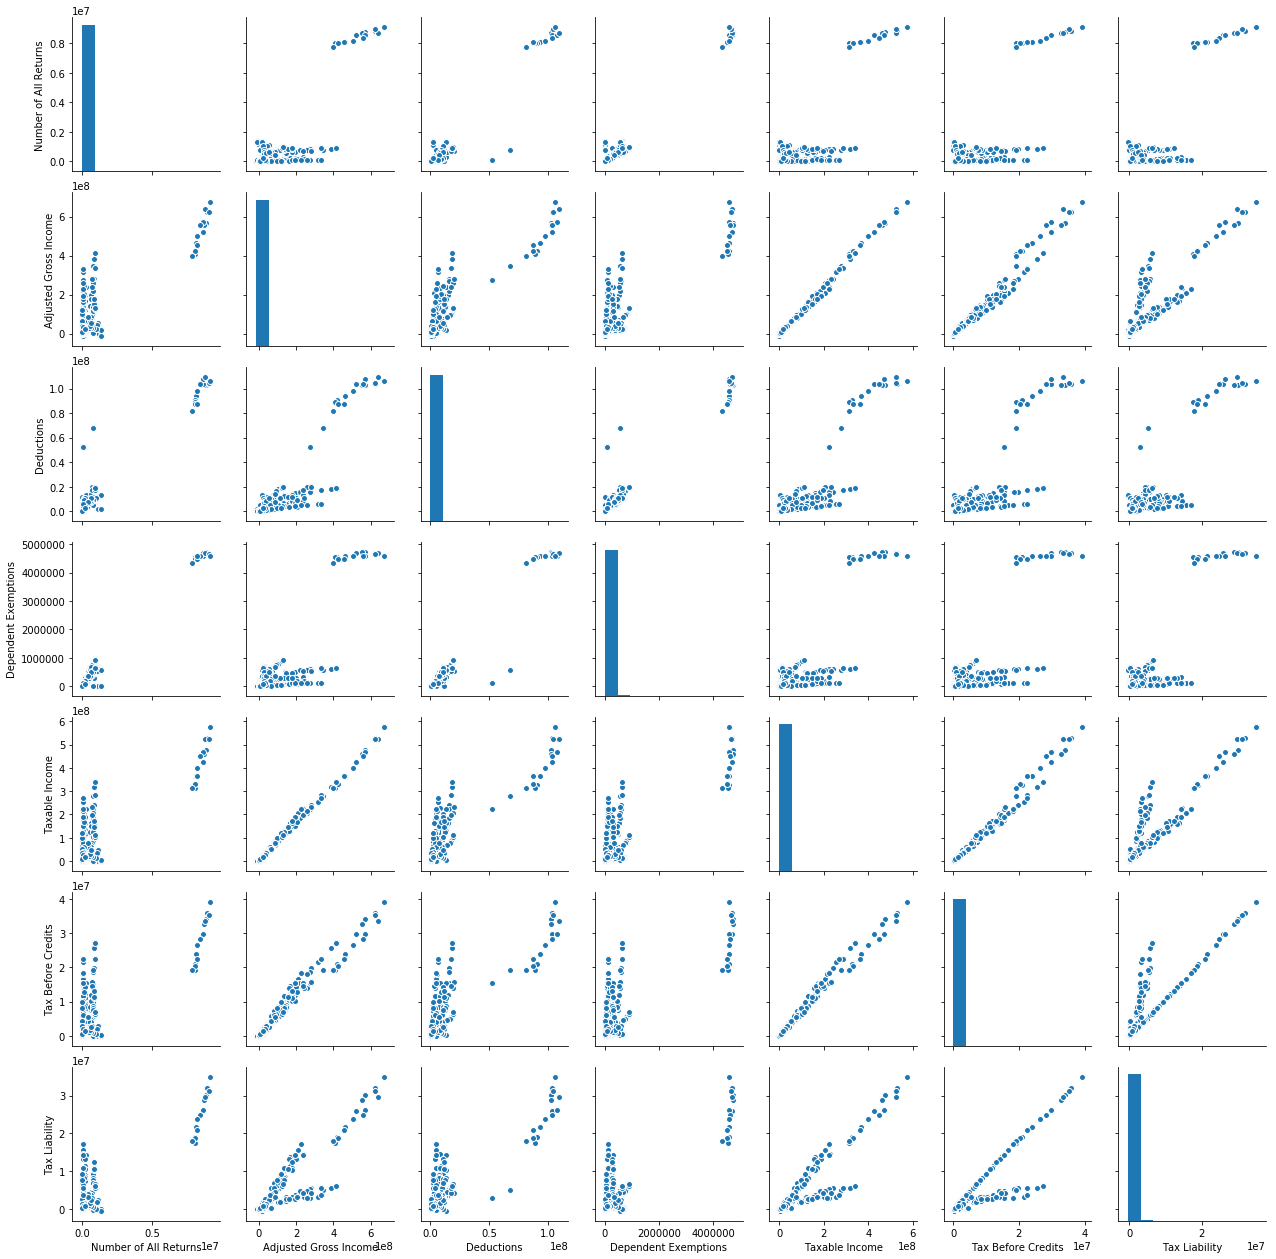

In [15]:
# вообще всё, но плохо что понятно
sns_plot = sns.pairplot(data[num_features])

Чтобы что-то понять, придётся повглядываться. <br>

Видно, что количество отчётов (Number of All Returns) делает резкий скачок для товарищей с очень высокими доходами и всем остальным, фактически данные разбиваются на две чёткие группы. <br>
Похоже с налоговыми вычетами (Deductions и Dependent Exemptions), интересно, что для этих трёх значений разбиение на 2 группы чёткое по обеим координатам, т.е. есть группа с низким числом отчётов и вычетами, и есть группа с большим числом отчётов и вычетами. <br>

Остальные 4 признака (доходы(Adjusted Gross Income и Taxable Income), и налоги с задолженностями(Tax Before Credits, Tax Liability)) более-менее кореллируют друг с другом, однако с задолженностью наблюдается более интересная ситуация: группа с более низкими доходами (и налогами) как бы ветвится на 2 подгруппы: у одной задолженность растёт быстрее с ростом доходов, а у другой медленнее; относительно основного налога (Tax Before Credits) у основной подгруппы почти линейный рост задолженности, а у другой подгруппы заметно более медленный рост задолженности. Возможно, группа с большими долгами - бизнесмены с большим денежным оборотом, из-за которого они не могут просто так сразу погасить налоги, потому что на руках денег мало; а люди со стабильной зарплатой быстрее разбираются с задолженностями.

In [89]:
# давайте теперь попытаемся найти более "успешные" районы
cur_data = (data.groupby('Place of Residence Name').mean())
cur_data.sort_values('Taxable Income',ascending=False).head(10)

,Tax Year,Number of All Returns,Adjusted Gross Income,Deductions,Dependent Exemptions,Taxable Income,Tax Before Credits,Tax Liability,Income Class
Place of Residence Name,,,,,,,,,
"Grand Total, Full-Year Resident",2006.807692,1.296020e+06,8.085056e+07,1.511373e+07,706088.030490,6.589931e+07,4.334163e+06,3.881685e+06,7.038462
"Grand Total, Full-Year Nonresident",2006.807692,1.142620e+05,3.836776e+07,2.907978e+06,83825.851135,3.178014e+07,2.382025e+06,6.745357e+05,7.038462
New York City - Manhattan,2006.807692,1.227583e+05,1.864421e+07,1.659106e+06,42332.592692,1.728060e+07,1.261867e+06,1.176446e+06,7.038462
New Jersey,2006.807692,5.538813e+04,9.747969e+06,1.064609e+06,48598.606519,8.407080e+06,5.895230e+05,3.528175e+05,7.038462
Nassau,2006.807692,9.958887e+04,8.541721e+06,1.481616e+06,58421.445260,7.137332e+06,4.817315e+05,4.524383e+05,7.038462
Westchester,2006.807692,6.635775e+04,7.984328e+06,1.030605e+06,39250.252529,6.989158e+06,4.932283e+05,4.483966e+05,7.038462
Suffolk,2006.807692,1.052122e+05,7.078449e+06,1.458617e+06,63120.509721,5.608160e+06,3.628038e+05,3.402875e+05,7.038462
New York City - Kings,2006.807692,1.526808e+05,6.252727e+06,1.579093e+06,87879.744942,4.650932e+06,2.840663e+05,2.288417e+05,7.038462
California,2006.807692,4.317692e+03,5.085493e+06,2.801779e+05,2138.837519,4.096621e+06,3.224245e+05,2.310627e+04,7.038462


In [ ]:
cur_data.sort_values('Adjusted Gross Income',ascending=False).head(3)

In [ ]:
cur_data.sort_values('Tax Before Credits',ascending=False).head(3)

In [ ]:
cur_data.sort_values('Tax Liability',ascending=False).head(3)

Первые две строки - нечто непонятное, о чём нет информации в сопутствующих датасету поясняющих документах... <br>
Возможно это люди, для которых не вышло установить точное место регистрации, которые активно перемещаются по США/за пределами США в течение налогового года.

Как видно, в среднем по Манхэттенену доходы и налоги максимальны (аналогично Москве?), Nassau и Suffolk - это Багамские острова и Англия соответственно, остальное в топе - американские штаты

In [101]:
data.groupby('Resident Type').mean()

,Tax Year,Number of All Returns,Adjusted Gross Income,Deductions,Dependent Exemptions,Taxable Income,Tax Before Credits,Tax Liability,Income Class
Resident Type,,,,,,,,,
Full-Year Nonresident,2007.750689,4848.673875,1.628143e+06,123401.259020,3557.174581,1.348597e+06,101081.727068,28624.017357,7.095481
Full-Year Resident,2006.777629,40150.465594,2.504636e+06,468217.944564,21874.485449,2.041452e+06,134263.582548,120247.020952,7.020703
Part-Year Resident,2006.807692,31853.403846,2.466580e+06,343904.343115,10955.355327,2.087256e+06,139067.901798,77154.422538,7.038462


Постоянные и полупостоянные резиденты в среднем зарабатывают больше, чем люди вне Нью-Йорка. <br>
Логично, что Full-Year Nonresidents имеют меньше налоговых отчётов, как оказалось в среднем почти в 10 раз меньше.

***Давайте придумывать гипотезы***

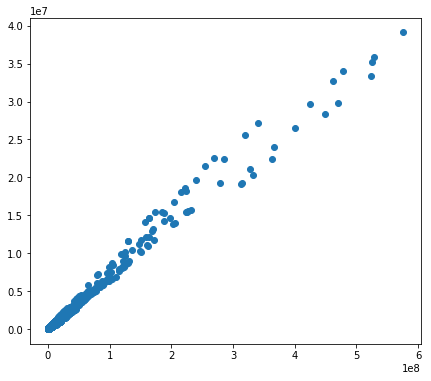

In [57]:
plt.figure(figsize=(7, 6))
plt.scatter(data['Taxable Income'], data['Tax Before Credits'])
plt.show()

Логично предположить (гипотезу), что чем больше у человека доход, тем больше он платит налогов
но это же тупо корреляция...

***Временные серии***

In [120]:
data_means = data.groupby('Tax Year').mean()
data_means

,Number of All Returns,Adjusted Gross Income,Deductions,Dependent Exemptions,Taxable Income,Tax Before Credits,Tax Liability,Income Class
Tax Year,,,,,,,,
1999,27945.462366,1.819190e+06,310293.688999,15886.141439,1.471039e+06,92264.887510,68816.996691,6.501241
2000,28220.614833,2.051913e+06,320905.243222,15954.728868,1.665048e+06,105527.425837,77882.619617,6.493620
2001,27963.491214,1.853955e+06,322957.948083,15951.373003,1.469249e+06,92210.636581,70759.056709,6.492013
2002,27976.656000,1.773136e+06,328133.160800,16183.608000,1.390334e+06,86896.728800,65729.317600,6.492000
2003,27954.787370,1.844385e+06,334619.869704,16259.598721,1.451545e+06,97072.446843,71303.574740,6.482814
2004,28378.813505,2.151000e+06,353494.743569,16457.898714,1.720604e+06,117161.781350,82251.950965,6.474277
2005,28181.672956,2.362567e+06,366212.047170,16175.025157,1.901146e+06,130771.853774,89186.439465,6.500000
2006,28106.192661,2.594086e+06,381626.902905,15852.764526,2.103795e+06,135987.895260,89950.207951,6.500000
2007,25027.036554,2.598202e+06,465503.694517,13775.142298,2.117099e+06,138786.714752,91212.286554,7.480418


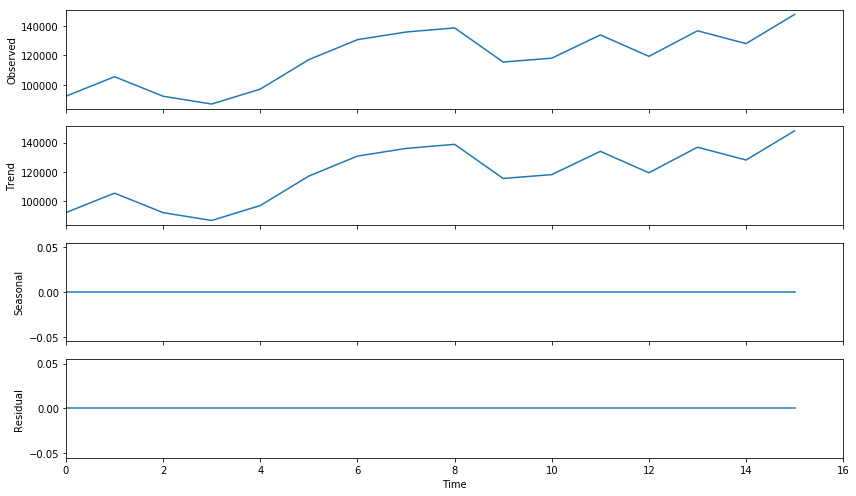

In [136]:
time_series = data_means['Tax Before Credits']
sm.tsa.seasonal_decompose(time_series.values, freq = 1).plot()
plt.show()